In [1]:
import json
import jsonlines
import os
import re
import torch
import warnings
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.stats import norm

from importlib import reload
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster

from scipy.sparse import csr_matrix

# Variables Setup

In [2]:
dataset_name = "hBreast"
models = ["BayesSpace"]
resolutions = [0.75]
spot_sizes = [50, 100, 75]
K_values = [17]

In [3]:
# BayXenSmooth Hyperparameters
BayXenSmooth_PCs = [3, 5, 10, 25]
BayesSpace_PCs = [3, 5, 10, 15, 25]
neighborhood_sizes = [1,2,3,4,5]
sample_for_assignment = False
concentration_amp = 1.0
spatial_norms = [0.05, 0.1]
aggs = ["sum", "mean", "weighted"]
num_neighboring_spots = [50]
kernels = ['umap', 'naive_distance']

# Load Data

In [4]:
# Path to your .gz file
file_path = f'data/{dataset_name}/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')

# drop cells without ids
df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

# drop blanks and controls
df_transcripts = df_transcripts[~df_transcripts["feature_name"].str.startswith('BLANK_') & ~df_transcripts["feature_name"].str.startswith('NegControl')]

# Other Metric Implementations

- Variation Index (TODO) If we want to compare competing methods clustering with our clustering.


In [5]:
def morans_i_cluster_similarity(clustering, locations, clusters, num_neighbors=100, kernel='umap', p=1, print_output=False):
    
    moran_clusters = ad.AnnData(locations)
    cluster_labels = clusters.values

    if kernel in ['umap', 'gauss']:
        sc.pp.neighbors(moran_clusters, n_neighbors=num_neighbors, use_rep='X', n_pcs=0, method=kernel)
    elif kernel == 'naive_distance':
        def naive_distance(x, p=1):
            return 1 / ((1 + x)**(1/p))

        nbrs = NearestNeighbors(n_neighbors=num_neighbors).fit(moran_clusters.X)
        distances, indices = nbrs.kneighbors(moran_clusters.X)
        connectivities = csr_matrix((moran_clusters.shape[0], moran_clusters.shape[0]))
        connectivities[np.arange(len(indices))[:, None], indices] = naive_distance(distances, p)
        moran_clusters.obsp["connectivities"] = connectivities

    # Calculate Moran's I for the binary presence of each cluster
    unique_clusters = np.unique(cluster_labels)
    morans_i_results = {}
    for cluster in unique_clusters:
        cluster_indicator = (cluster_labels == cluster).astype(int)
        morans_i = sc.metrics.morans_i(moran_clusters.obsp["connectivities"], vals=cluster_indicator)
        morans_i_results[cluster] = morans_i

    return np.mean(list(morans_i_results.values()))

In [6]:
def gearys_c_cluster_similarity(clustering, locations, clusters, num_neighbors=100, kernel='umap', p=1, print_output=False):

    gearys_clusters = ad.AnnData(locations)

    cluster_labels = clusters.values
    # Calculate Gearys C for the binary presence of each cluster
    if kernel in ['umap', 'gauss']:
        sc.pp.neighbors(gearys_clusters, n_neighbors=num_neighbors, use_rep='X', n_pcs=0, method=kernel)
    elif kernel == 'naive_distance':
        def naive_distance(x, p=1):
            return 1 / ((1 + x)**(1/p))

        nbrs = NearestNeighbors(n_neighbors=num_neighbors).fit(gearys_clusters.X)
        distances, indices = nbrs.kneighbors(gearys_clusters.X)
        connectivities = csr_matrix((gearys_clusters.shape[0], gearys_clusters.shape[0]))
        connectivities[np.arange(len(indices))[:, None], indices] = naive_distance(distances, p)
        gearys_clusters.obsp["connectivities"] = connectivities

    # Calculate Moran's I for the binary presence of each cluster
    unique_clusters = np.unique(cluster_labels)
    gearys_c_results = {}
    for cluster in unique_clusters:
        cluster_indicator = (cluster_labels == cluster).astype(int)
        gearys_c = sc.metrics.gearys_c(gearys_clusters, vals=cluster_indicator)
        gearys_c_results[cluster] = gearys_c

    return np.mean(list(gearys_c_results.values()))

In [7]:
def save_results(results, directory, metric_name, specification=None):
    subdirectory = f"{specification}" if specification else ""
    full_path = f"{directory}/{subdirectory}"
    
    # Create the directory if it doesn't exist
    os.makedirs(full_path, exist_ok=True)
    
    with jsonlines.open(f"{full_path}/{metric_name}.jsonl", mode='w') as writer:
        try:
            for key, value in results.items():
                writer.write({key: value})
        except AttributeError: # b/c it's not a dictionary so .items() fails
            writer.write(results)

# Calculate the Silhouette Score (and other metrics of note.)

In [47]:
from IPython.utils import io

with io.capture_output():
    for spot_size in spot_sizes:
        print(spot_size)
        clustering = XeniumCluster(data=df_transcripts, dataset_name=dataset_name)
        clustering.set_spot_size(spot_size)
        clustering.create_spot_data(third_dim=False, save_data=True)
        locations = clustering.xenium_spot_data.obs[["row", "col"]]
        for K in K_values:
            for model in models:
                results_dir = f"results/hBreast/{model}"
                for root, dirs, files in os.walk(results_dir):
                    for file in files:
                        print(os.path.join(root, file), (file == f"clusters_K={K}.csv" or (file.endswith(".csv") and "clusters_RES" in file)) and f"/{spot_size}/" in root)
                        # Check if the file is named morans_i_by_gene.json
                        if model == "BayXenSmooth":
                            if (file == f"clusters_K={K}.csv" or (file.endswith(".csv") and "clusters_RES" in file)) and f"/SPOTSIZE={spot_size}/" in os.path.join(root, file):
                                for neighboring_spots in num_neighboring_spots:
                                    for kernel in kernels:
                                        clusters = pd.read_csv(os.path.join(root, file))[f"{model} cluster"]
                                        morans_i_file = f"{root}/{kernel}/{neighboring_spots}/morans_i.jsonl"
                                        if not os.path.exists(morans_i_file):
                                            save_results(morans_i_cluster_similarity(clustering, locations, clusters, num_neighbors=neighboring_spots, kernel=kernel), root, "morans_i", specification=f"{kernel}/{neighboring_spots}")
                                        gearys_c_file = f"{root}/{kernel}/{neighboring_spots}/gearys_c.jsonl"
                                        if not os.path.exists(gearys_c_file):
                                            save_results(gearys_c_cluster_similarity(clustering, locations, clusters, num_neighbors=neighboring_spots, kernel=kernel), root, "gearys_c", specification=f"{kernel}/{neighboring_spots}")
                                        silhouette_score_file = f"{root}/silhouette_score.jsonl"
                                        if not os.path.exists(silhouette_score_file):
                                            save_results(silhouette_score(locations, clusters), root, "silhouette_score")
                        else:
                            if (file == f"clusters_K={K}.csv" or (file.endswith(".csv") and "clusters_RES" in file)) and f"/{spot_size}/" in os.path.join(root, file):
                                for neighboring_spots in num_neighboring_spots:
                                    for kernel in kernels:
                                        clusters = pd.read_csv(os.path.join(root, file))[f"{model} cluster"]
                                        morans_i_file = f"{root}/{kernel}/{neighboring_spots}/morans_i.jsonl"
                                        if not os.path.exists(morans_i_file):
                                            save_results(morans_i_cluster_similarity(clustering, locations, clusters, num_neighbors=neighboring_spots, kernel=kernel), root, "morans_i", specification=f"{kernel}/{neighboring_spots}")
                                        gearys_c_file = f"{root}/{kernel}/{neighboring_spots}/gearys_c.jsonl"
                                        if not os.path.exists(gearys_c_file):
                                            save_results(gearys_c_cluster_similarity(clustering, locations, clusters, num_neighbors=neighboring_spots, kernel=kernel), root, "gearys_c", specification=f"{kernel}/{neighboring_spots}")
                                        silhouette_score_file = f"{root}/silhouette_score.jsonl"
                                        if not os.path.exists(silhouette_score_file):
                                            save_results(silhouette_score(locations, clusters), root, "silhouette_score")

# Marker Gene Autocorrelation

In [8]:
MARKER_GENES = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]

In [9]:
def gene_morans_i(clustering, moran_clusters, clusters, num_neighbors=100, kernel='umap', p=1, marker_genes=MARKER_GENES, print_output=False):

    # Create a binary adjacency matrix indicating if points are in the same cluster
    cluster_labels = clusters.values
    same_cluster = (cluster_labels[:, None] == cluster_labels).astype(int)

    if kernel == 'umap':
        sc.pp.neighbors(moran_clusters, n_neighbors=num_neighbors, use_rep='X', n_pcs=0, method=kernel)
        moran_clusters.obsp["adjacency"] = moran_clusters.obsp["connectivities"].multiply(csr_matrix(same_cluster))
    elif kernel == 'gauss':
        sc.pp.neighbors(moran_clusters, n_neighbors=num_neighbors, use_rep='X', n_pcs=0, method=kernel)
        moran_clusters.obsp["adjacency"] = moran_clusters.obsp["connectivities"].multiply(csr_matrix(same_cluster))
    elif kernel == 'naive_distance':
        def naive_distance(x, p=1):
            return 1 / ((1 + x)**(1/p))

        nbrs = NearestNeighbors(n_neighbors=num_neighbors).fit(moran_clusters.X)
        distances, indices = nbrs.kneighbors(moran_clusters.X)
        connectivities = csr_matrix((moran_clusters.shape[0], moran_clusters.shape[0]))
        connectivities[np.arange(len(indices))[:, None], indices] = naive_distance(distances, p)
        moran_clusters.obsp["connectivities"] = connectivities
        moran_clusters.obsp["adjacency"] = moran_clusters.obsp["connectivities"].multiply(csr_matrix(same_cluster))
    elif kernel == 'basic':
        moran_clusters.obsp["adjacency"] = csr_matrix(same_cluster)
    else:
        warnings.warn(f"Kernel '{kernel}' not implemented. Using 'basic' kernel instead. We recommend 'umap'.", UserWarning)
        kernel = 'basic'
        moran_clusters.obsp["adjacency"] = csr_matrix(same_cluster)

    # Calculate Moran's I for the genes
    morans_i = sc.metrics.morans_i(moran_clusters.obsp["adjacency"], vals=clustering.xenium_spot_data.X.T)
    morans_i_dict = dict(zip(clustering.xenium_spot_data.var.index, morans_i))

    # Print the number of non-zero adjacencies
    if print_output:
        num_nonzero = moran_clusters.obsp["adjacency"].getnnz()
        print(f"Number of non-zero adjacencies: {num_nonzero}")
        for gene in marker_genes:
            print(num_neighbors, gene, morans_i_dict[gene])

    return morans_i_dict

In [10]:
def gene_gearys_c(clustering, gearys_clusters, clusters, num_neighbors=100):

    # Create a binary adjacency matrix indicating if points are in the same cluster
    cluster_labels = clusters.values
    same_cluster = (cluster_labels[:, None] == cluster_labels).astype(int)
    gearys_clusters.obsp["adjacency"] = gearys_clusters.obsp["connectivities"].multiply(csr_matrix(same_cluster))
    print("Connectivities formed.")

    # Calculate Geary's C for the genes
    gearys_c= sc.metrics.gearys_c(gearys_clusters.obsp["adjacency"], vals=clustering.xenium_spot_data.X.T)

    gearys_c_dict = dict(zip(clustering.xenium_spot_data.var.index, gearys_c))

    return gearys_c_dict

In [12]:
models = ["BayesSpace", "Leiden", "Louvain", "K-Means", "Hierarchical_No_Spatial", "mclust"]
num_neighboring_spots = [50]
kernels = ['umap']
spot_sizes = [50]
K = 17

In [ ]:
for spot_size in spot_sizes:
    clustering = XeniumCluster(data=df_transcripts, dataset_name=dataset_name)
    clustering.set_spot_size(spot_size)
    clustering.create_spot_data(third_dim=False, save_data=True)
    locations = clustering.xenium_spot_data.obs[["row", "col"]]
    moran_clusters = ad.AnnData(locations)
    gearys_clusters = ad.AnnData(locations)
    for model in models:
        print(model)

        moran_clusters = ad.AnnData(locations)
        gearys_clusters = ad.AnnData(locations)

        # Define the directory where the results are stored
        results_dir = f"results/hBreast/{model}"

        # Loop through all subdirectories in the results directory
        for root, dirs, files in os.walk(results_dir):
            for file in files:
                # Check if the file is named morans_i_by_gene.json
                if (file == f"clusters_K={K}.csv" or (file.endswith(".csv") and "clusters_RES" in file)) and f"/{spot_size}/" in root:
                    print(os.path.join(root, file))
                    for neighboring_spots in num_neighboring_spots:
                        for kernel in kernels:

                            clusters = pd.read_csv(os.path.join(root, file))[f"{model} cluster"]
                            save_results(gene_morans_i(clustering, moran_clusters, clusters, num_neighbors=neighboring_spots, kernel=kernel, print_output=False), root, "morans_i_by_gene", specification=f"{kernel}/{neighboring_spots}")

# Specific Method Marker Gene Ranking

In [250]:
# Define the directory where the results are stored
results_dir = "results/hBreast/Leiden"
morans_i_dict = {}
marker_gene_ranking_dict = {gene: {"rank": float('inf')} for gene in MARKER_GENES}
for root, dirs, files in os.walk(results_dir):
    for file in files:
        # Check if the file is named morans_i_by_gene.json
        if file == "morans_i_by_gene.jsonl":
            used_runs = ["Leiden/0.75", "Louvain/1.0"]

            # Construct the full path to the file
            file_path = os.path.join(root, file)
            if not any(x in file_path for x in ["Leiden", "Louvain"]) or any(x in file_path for x in used_runs):
                # Open and read the file
                with open(file_path, 'r') as f:
                    # Load the JSON data
                    data = [line for line in jsonlines.Reader(f)]
                    data = sorted(data, key=lambda x: next(iter(x.values())), reverse=True)
                    for i, data_point in enumerate(data):
                        gene, morans_i_val = next(iter(data_point.items()))
                        if gene in MARKER_GENES:
                            if marker_gene_ranking_dict[gene]["rank"] > (i + 1):
                                marker_gene_ranking_dict[gene]["rank"] = (i + 1)
                                marker_gene_ranking_dict[gene]["filepath"] = file_path

In [251]:
marker_gene_ranking_dict

{'BANK1': {'rank': 3,
  'filepath': 'results/hBreast/Leiden/0.75/clusters/50/umap/50/morans_i_by_gene.jsonl'},
 'CEACAM6': {'rank': 206,
  'filepath': 'results/hBreast/Leiden/0.75/clusters/50/umap/400/morans_i_by_gene.jsonl'},
 'FASN': {'rank': 14,
  'filepath': 'results/hBreast/Leiden/0.75/clusters/50/umap/400/morans_i_by_gene.jsonl'},
 'FGL2': {'rank': 145,
  'filepath': 'results/hBreast/Leiden/0.75/clusters/50/umap/100/morans_i_by_gene.jsonl'},
 'IL7R': {'rank': 14,
  'filepath': 'results/hBreast/Leiden/0.75/clusters/50/umap/50/morans_i_by_gene.jsonl'},
 'KRT6B': {'rank': 30,
  'filepath': 'results/hBreast/Leiden/0.75/clusters/50/umap/50/morans_i_by_gene.jsonl'},
 'POSTN': {'rank': 123,
  'filepath': 'results/hBreast/Leiden/0.75/clusters/50/umap/400/morans_i_by_gene.jsonl'},
 'TCIM': {'rank': 71,
  'filepath': 'results/hBreast/Leiden/0.75/clusters/50/umap/100/morans_i_by_gene.jsonl'}}

# BayXenSmooth Best Moran's I

In [32]:
# Define the directory where the results are stored
results_dir = "results/hBreast/BayXenSmooth"

# Loop through all subdirectories in the results directory
morans_i_dict = {}
for gene_name in MARKER_GENES:
    current_max_expression = 0
    current_best_mpd = float('inf')
    for root, dirs, files in os.walk(results_dir):
        for file in files:
            # Check if the file is named morans_i_by_gene.json
            if file == "morans_i_by_gene.jsonl":
                # Construct the full path to the file
                file_path = os.path.join(root, file)
                # Open and read the file
                with open(file_path, 'r') as f:
                    # Load the JSON data
                    data = [line for line in jsonlines.Reader(f)]
                    # Print the data to verify it's been loaded
                    morans_i = [x for x in data if gene_name in x]
                    if morans_i[0][gene_name] > current_max_expression and "SPOTSIZE=50" in file_path and "umap/50" in file_path:# and "K-Means" in file_path:
                        current_max_filepath = file_path
                        current_max_expression = morans_i[0][gene_name]
                        mpd_root = root
                        pattern = r"(?:umap|naive_distance|gauss|basic)/\d+"
                        mpd_root = re.sub(pattern, "", mpd_root)
                        mpd_dir = mpd_root.replace("clusters", "mpd")
                        try:
                            mpd_file = next((f for f in os.listdir(mpd_dir) if f.endswith(".json")), None)
                            if mpd_file:
                                with open(os.path.join(mpd_dir, mpd_file)) as f:
                                    mpd_dict = json.load(f)
                                    if len(mpd_dict) == K:
                                        current_best_mpd = sum(mpd_dict.values()) / 1_000
                                    else:
                                        current_best_mpd = (sum(mpd_dict.values()) / 1_000, f"(but K* = {len(mpd_dict)})")
                        except FileNotFoundError:
                            print(os.path.join(mpd_dir, mpd_file), "has missing MPD.")
                        with open(file_path.replace("morans_i_by_gene.jsonl", "morans_i.jsonl")) as g:
                            morans_i_spatial = [line for line in jsonlines.Reader(g)][0]
    morans_i_dict[gene_name] = current_max_expression, current_max_filepath, current_best_mpd, morans_i_spatial

results/hBreast/BayXenSmooth/mpd/PCA/25/INIT=K-Means/NEIGHBORSIZE=2/NUMCLUSTERS=17/SAMPLEFORASSIGNMENT=True/SPATIALPRIORMULT=DIRECT/SPOTSIZE=50/AGG=mean/MU_PRIOR=2.5/SIGMA_PRIOR=1.0/LOGITS_PRIOR=25.0/LEARN_GLOBAL_VARS=True/mpd.json has missing MPD.
results/hBreast/BayXenSmooth/mpd/PCA/25/INIT=K-Means/NEIGHBORSIZE=1/NUMCLUSTERS=17/SAMPLEFORASSIGNMENT=True/SPATIALPRIORMULT=DIRECT/SPOTSIZE=50/AGG=mean/MU_PRIOR=2.5/SIGMA_PRIOR=1.0/LOGITS_PRIOR=10.0/LEARN_GLOBAL_VARS=True/mpd.json has missing MPD.
results/hBreast/BayXenSmooth/mpd/PCA/25/INIT=K-Means/NEIGHBORSIZE=1/NUMCLUSTERS=17/SAMPLEFORASSIGNMENT=True/SPATIALPRIORMULT=DIRECT/SPOTSIZE=50/AGG=mean/MU_PRIOR=10.0/SIGMA_PRIOR=1.0/LOGITS_PRIOR=25.0/LEARN_GLOBAL_VARS=True/mpd.json has missing MPD.
results/hBreast/BayXenSmooth/mpd/PCA/25/INIT=K-Means/NEIGHBORSIZE=1/NUMCLUSTERS=17/SAMPLEFORASSIGNMENT=True/SPATIALPRIORMULT=DIRECT/SPOTSIZE=50/AGG=mean/MU_PRIOR=2.5/SIGMA_PRIOR=1.0/LOGITS_PRIOR=10.0/LEARN_GLOBAL_VARS=True/mpd.json has missing MPD.
res

In [33]:
morans_i_dict

{'BANK1': (1.1538652141393557,
  'results/hBreast/BayXenSmooth/clusters/PCA/25/INIT=K-Means/NEIGHBORSIZE=1/NUMCLUSTERS=17/SAMPLEFORASSIGNMENT=True/SPATIALPRIORMULT=DIRECT/SPOTSIZE=50/AGG=mean/MU_PRIOR=10.0/SIGMA_PRIOR=1.0/LOGITS_PRIOR=25.0/LEARN_GLOBAL_VARS=True/umap/50/morans_i_by_gene.jsonl',
  58.28332822887453,
  [0.34343848668397625]),
 'CEACAM6': (0.4061224468124115,
  'results/hBreast/BayXenSmooth/clusters/PCA/3/INIT=mclust/NEIGHBORSIZE=1/NUMCLUSTERS=17/SAMPLEFORASSIGNMENT=True/SPATIALPRIORMULT=DIRECT/SPOTSIZE=50/AGG=mean/MU_PRIOR=0.1/SIGMA_PRIOR=0.25/LOGITS_PRIOR=5.0/LEARN_GLOBAL_VARS=False/umap/50/morans_i_by_gene.jsonl',
  (50.3589368628534, '(but K* = 14)'),
  [0.37463664908540145]),
 'FASN': (1.1366610517413984,
  'results/hBreast/BayXenSmooth/clusters/PCA/3/INIT=mclust/NEIGHBORSIZE=1/NUMCLUSTERS=17/SAMPLEFORASSIGNMENT=True/SPATIALPRIORMULT=DIRECT/SPOTSIZE=50/AGG=mean/MU_PRIOR=0.1/SIGMA_PRIOR=0.25/LOGITS_PRIOR=5.0/LEARN_GLOBAL_VARS=False/umap/50/morans_i_by_gene.jsonl',
  (

# Best Moran's I

In [38]:
import os
import json

MARKER_GENES = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]

# Define the directory where the results are stored
results_dir = "results/hBreast"

# Loop through all subdirectories in the results directory
morans_i_dict = {}
for gene_name in MARKER_GENES:
    current_max_expression = 0
    current_best_mpd = float('inf')
    for root, dirs, files in os.walk(results_dir):
        for file in files:
            # Check if the file is named morans_i_by_gene.json
            if file == "morans_i_by_gene.jsonl":
                # Construct the full path to the file
                file_path = os.path.join(root, file)
                # Open and read the file
                with open(file_path, 'r') as f:
                    # Load the JSON data
                    data = [line for line in jsonlines.Reader(f)]
                    # Print the data to verify it's been loaded
                    morans_i = [x for x in data if gene_name in x]
                    unused_runs = ["Leiden/2.0", "Leiden/1.5", "Louvain/2.0", "Louvain/1.5"]
                    if morans_i[0][gene_name] > current_max_expression and "50/" in file_path and not any(x in file_path for x in unused_runs) and "umap/50" in file_path:
                        current_max_filepath = file_path
                        current_max_expression = morans_i[0][gene_name]
                        mpd_root = root
                        pattern = r"(?:umap|naive_distance|gauss|basic)/\d+"
                        mpd_root = re.sub(pattern, "", mpd_root)
                        mpd_dir = mpd_root.replace("clusters", "mpd")
                        try:
                            mpd_file = next((f for f in os.listdir(mpd_dir) if f.endswith(".json")), None)
                            if mpd_file:
                                with open(os.path.join(mpd_dir, mpd_file)) as f:
                                    mpd_dict = json.load(f)
                                    if len(mpd_dict) == K:
                                        current_best_mpd = sum(mpd_dict.values()) / 1_000
                                    else:
                                        current_best_mpd = (sum(mpd_dict.values()) / 1_000, f"(but K* = {len(mpd_dict)})")
                        except FileNotFoundError:
                            print(os.path.join(mpd_dir, mpd_file), "has missing MPD.")
                        with open(file_path.replace("morans_i_by_gene.jsonl", "morans_i.jsonl")) as g:
                            morans_i_spatial = [line for line in jsonlines.Reader(g)][0]
    morans_i_dict[gene_name] = current_max_expression, current_max_filepath, current_best_mpd, morans_i_spatial

results/hBreast/BayXenSmooth/mpd/PCA/25/INIT=K-Means/NEIGHBORSIZE=2/NUMCLUSTERS=17/SAMPLEFORASSIGNMENT=True/SPATIALPRIORMULT=DIRECT/SPOTSIZE=50/AGG=mean/MU_PRIOR=2.5/SIGMA_PRIOR=1.0/LOGITS_PRIOR=25.0/LEARN_GLOBAL_VARS=True/mpd.json has missing MPD.
results/hBreast/BayXenSmooth/mpd/PCA/25/INIT=K-Means/NEIGHBORSIZE=1/NUMCLUSTERS=17/SAMPLEFORASSIGNMENT=True/SPATIALPRIORMULT=DIRECT/SPOTSIZE=50/AGG=mean/MU_PRIOR=2.5/SIGMA_PRIOR=1.0/LOGITS_PRIOR=10.0/LEARN_GLOBAL_VARS=True/mpd.json has missing MPD.
results/hBreast/BayXenSmooth/mpd/PCA/25/INIT=K-Means/NEIGHBORSIZE=1/NUMCLUSTERS=17/SAMPLEFORASSIGNMENT=True/SPATIALPRIORMULT=DIRECT/SPOTSIZE=50/AGG=mean/MU_PRIOR=10.0/SIGMA_PRIOR=1.0/LOGITS_PRIOR=25.0/LEARN_GLOBAL_VARS=True/mpd.json has missing MPD.
results/hBreast/BayXenSmooth/mpd/PCA/25/INIT=K-Means/NEIGHBORSIZE=1/NUMCLUSTERS=17/SAMPLEFORASSIGNMENT=True/SPATIALPRIORMULT=DIRECT/SPOTSIZE=50/AGG=mean/MU_PRIOR=2.5/SIGMA_PRIOR=1.0/LOGITS_PRIOR=10.0/LEARN_GLOBAL_VARS=True/mpd.json has missing MPD.
res

In [39]:
morans_i_dict

{'BANK1': (1.5801865538164903,
  'results/hBreast/Leiden/1.0/clusters/50/umap/50/morans_i_by_gene.jsonl',
  (65.24583595322189, '(but K* = 20)'),
  0.29356070708548604),
 'CEACAM6': (0.45201729785014083,
  'results/hBreast/Hierarchical_No_Spatial/17/clusters/50/umap/50/morans_i_by_gene.jsonl',
  59.31856462687449,
  0.18988122987313394),
 'FASN': (1.2998799957085951,
  'results/hBreast/mclust/3/17/clusters/50/umap/50/morans_i_by_gene.jsonl',
  (54.209745689054785, '(but K* = 15)'),
  0.22370076758354743),
 'FGL2': (0.6738512168407966,
  'results/hBreast/K-Means/17/clusters/50/umap/50/morans_i_by_gene.jsonl',
  61.97873758661273,
  0.24597487205847823),
 'IL7R': (1.3157662790488807,
  'results/hBreast/K-Means/17/clusters/50/umap/50/morans_i_by_gene.jsonl',
  61.97873758661273,
  0.24597487205847823),
 'KRT6B': (1.063454558166665,
  'results/hBreast/Leiden/1.0/clusters/50/umap/50/morans_i_by_gene.jsonl',
  (65.24583595322189, '(but K* = 20)'),
  0.29356070708548604),
 'POSTN': (0.6681536

# Specific Methods Comparison

In [46]:
import os
import json

MARKER_GENES = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]

# Define the directory where the results are stored
results_dir = "results/hBreast/BayesSpace"

# Loop through all subdirectories in the results directory
morans_i_dict = {}
for gene_name in MARKER_GENES:
    current_max_expression = 0
    current_best_mpd = float('inf')
    for root, dirs, files in os.walk(results_dir):
        for file in files:
            # Check if the file is named morans_i_by_gene.json
            if file == "morans_i_by_gene.jsonl":
                # Construct the full path to the file
                file_path = os.path.join(root, file)
                # Open and read the file
                with open(file_path, 'r') as f:
                    # Load the JSON data
                    data = [line for line in jsonlines.Reader(f)]
                    # Print the data to verify it's been loaded
                    morans_i = [x for x in data if gene_name in x]
                    used_runs = ["Leiden/0.75", "Louvain/1.0"]
                    if "BayesSpace" in file_path:
                        if morans_i[0][gene_name] > current_max_expression and ("mclust/50" in file_path or "kmeans/50" in file_path) and "umap/50" in file_path:
                            current_max_filepath = file_path
                            current_max_expression = morans_i[0][gene_name]
                            mpd_root = root
                            pattern = r"(?:umap|naive_distance|gauss|basic)/\d+"
                            mpd_root = re.sub(pattern, "", mpd_root)
                            mpd_dir = mpd_root.replace("clusters", "mpd")
                            try:
                                mpd_file = next((f for f in os.listdir(mpd_dir) if f.endswith(".json")), None)
                                if mpd_file:
                                    with open(os.path.join(mpd_dir, mpd_file)) as f:
                                        mpd_dict = json.load(f)
                                        if len(mpd_dict) == K:
                                            current_best_mpd = sum(mpd_dict.values()) / 1_000
                                        else:
                                            current_best_mpd = (sum(mpd_dict.values()) / 1_000, f"(but K* = {len(mpd_dict)})")
                            except FileNotFoundError:
                                print(os.path.join(mpd_dir, mpd_file), "has missing MPD.")
                            with open(file_path.replace("morans_i_by_gene.jsonl", "morans_i.jsonl")) as g:
                                morans_i_spatial = [line for line in jsonlines.Reader(g)][0]
                    else:
                        if not any(x in file_path for x in ["Leiden", "Louvain"]) or any(x in file_path for x in used_runs):
                            if morans_i[0][gene_name] > current_max_expression and "/50/" and "umap/50" in file_path:
                                current_max_filepath = file_path
                                current_max_expression = morans_i[0][gene_name]
                                mpd_root = root
                                pattern = r"(?:umap|naive_distance|gauss|basic)/\d+"
                                mpd_root = re.sub(pattern, "", mpd_root)
                                mpd_dir = mpd_root.replace("clusters", "mpd")
                                try:
                                    mpd_file = next((f for f in os.listdir(mpd_dir) if f.endswith(".json")), None)
                                    if mpd_file:
                                        with open(os.path.join(mpd_dir, mpd_file)) as f:
                                            mpd_dict = json.load(f)
                                            if len(mpd_dict) == K:
                                                current_best_mpd = sum(mpd_dict.values()) / 1_000
                                            else:
                                                current_best_mpd = (sum(mpd_dict.values()) / 1_000, f"(but K* = {len(mpd_dict)})")
                                except FileNotFoundError:
                                    print(os.path.join(mpd_dir, mpd_file), "has missing MPD.")
                                with open(file_path.replace("morans_i_by_gene.jsonl", "morans_i.jsonl")) as g:
                                    morans_i_spatial = [line for line in jsonlines.Reader(g)][0]
    morans_i_dict[gene_name] = current_max_expression, current_max_filepath, current_best_mpd, morans_i_spatial

In [47]:
morans_i_dict

{'BANK1': (1.5227496568889738,
  'results/hBreast/BayesSpace/5/17/clusters/kmeans/50/1.00/umap/50/morans_i_by_gene.jsonl',
  59.325748413275434,
  0.24380689970323294),
 'CEACAM6': (0.42085271665163043,
  'results/hBreast/BayesSpace/25/17/clusters/kmeans/50/1.00/umap/50/morans_i_by_gene.jsonl',
  53.3536543188325,
  0.39774777637090164),
 'FASN': (1.2173662080573384,
  'results/hBreast/BayesSpace/3/17/clusters/mclust/50/2.75/umap/50/morans_i_by_gene.jsonl',
  60.019838073897894,
  0.3012775376608047),
 'FGL2': (0.6029515211776677,
  'results/hBreast/BayesSpace/5/17/clusters/kmeans/50/1.00/umap/50/morans_i_by_gene.jsonl',
  59.325748413275434,
  0.24380689970323294),
 'IL7R': (1.2781109784662197,
  'results/hBreast/BayesSpace/5/17/clusters/kmeans/50/1.00/umap/50/morans_i_by_gene.jsonl',
  59.325748413275434,
  0.24380689970323294),
 'KRT6B': (0.9197226340368896,
  'results/hBreast/BayesSpace/10/17/clusters/mclust/50/1.00/umap/50/morans_i_by_gene.jsonl',
  57.49371378353848,
  0.30526283

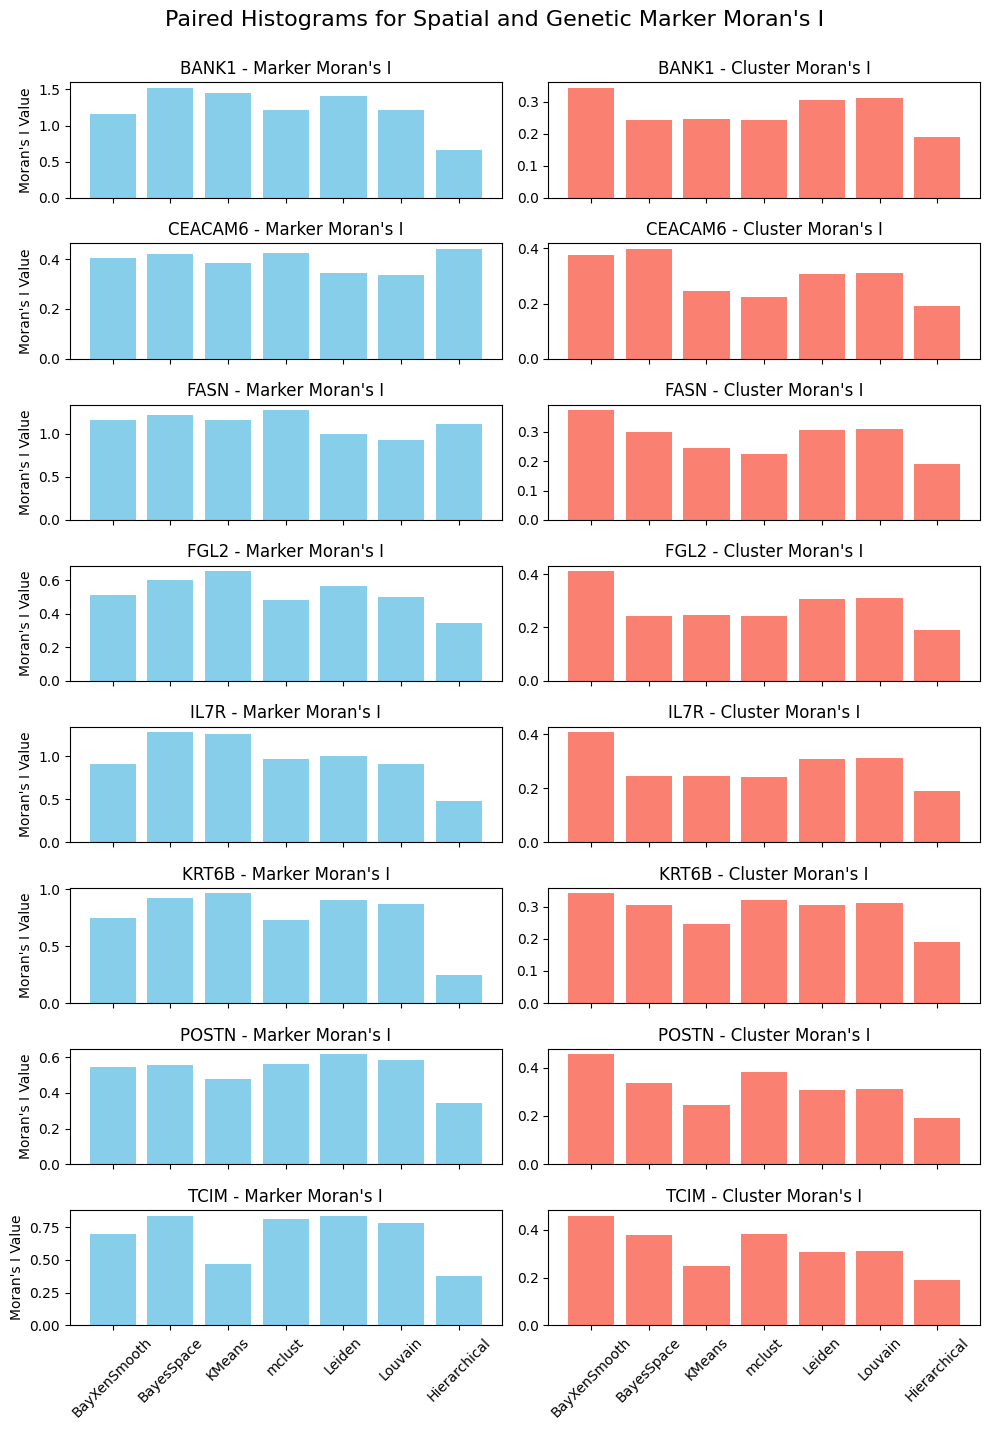

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for Moran's I values (marker genes) and Moran's I for cluster membership indicators
data = {
    'Gene': ['BANK1', 'CEACAM6', 'FASN', 'FGL2', 'IL7R', 'KRT6B', 'POSTN', 'TCIM'],
    'BayXenSmooth_Marker': [1.154, 0.406, 1.156, 0.513, 0.905, 0.751, 0.547, 0.701],
    'BayesSpace_Marker': [1.523, 0.421, 1.217, 0.603, 1.278, 0.920, 0.554, 0.840],
    'KMeans_Marker': [1.449, 0.385, 1.158, 0.654, 1.256, 0.963, 0.478, 0.472],
    'mclust_Marker': [1.220, 0.424, 1.276, 0.485, 0.970, 0.732, 0.561, 0.810],
    'Leiden_Marker': [1.403, 0.343, 0.995, 0.564, 1.007, 0.908, 0.615, 0.834],
    'Louvain_Marker': [1.219, 0.338, 0.929, 0.497, 0.904, 0.870, 0.584, 0.781],
    'Hierarchical_Marker': [0.656, 0.441, 1.119, 0.343, 0.483, 0.251, 0.343, 0.375],
    'BayXenSmooth_Cluster': [0.343, 0.375, 0.375, 0.411, 0.407, 0.341, 0.455, 0.459],
    'BayesSpace_Cluster': [0.244, 0.398, 0.301, 0.244, 0.244, 0.305, 0.335, 0.377],
    'KMeans_Cluster': [0.246, 0.246, 0.246, 0.246, 0.246, 0.246, 0.246, 0.246],
    'mclust_Cluster': [0.242, 0.224, 0.224, 0.242, 0.242, 0.321, 0.381, 0.381],
    'Leiden_Cluster': [0.306, 0.306, 0.306, 0.306, 0.306, 0.306, 0.306, 0.306],
    'Louvain_Cluster': [0.311, 0.311, 0.311, 0.311, 0.311, 0.311, 0.311, 0.311],
    'Hierarchical_Cluster': [0.190, 0.190, 0.190, 0.190, 0.190, 0.190, 0.190, 0.190]
}

# Convert to DataFrame and reshape for plotting
df = pd.DataFrame(data)
df_melted = pd.melt(df, id_vars=['Gene'], var_name='Method_Type', value_name='Moran_I')

# Split 'Method_Type' into 'Method' and 'Type' (Marker or Cluster)
df_melted[['Method', 'Type']] = df_melted['Method_Type'].str.split('_', expand=True)
df_marker = df_melted[df_melted['Type'] == 'Marker']
df_cluster = df_melted[df_melted['Type'] == 'Cluster']

# Merge marker and cluster data
df_combined = pd.merge(df_marker, df_cluster, on=['Gene', 'Method'], suffixes=('_Marker', '_Cluster'))

# Set up a 2-row grid of subplots for paired histograms per gene
fig, axes = plt.subplots(nrows=len(df['Gene']), ncols=2, figsize=(10, 15), sharex=True, sharey=False)  # Adjusted figure size for better fit in an academic paper
fig.suptitle("Paired Histograms for Spatial and Genetic Marker Moran's I", fontsize=16, y=0.95)  # Adjusted font size for better readability

# Plot histograms for each gene's Moran's I values by method, one for spatial and one for genetic marker Moran's I
for i, gene in enumerate(df['Gene']):
    # Filter data for the current gene
    gene_data_marker = df_combined[(df_combined['Gene'] == gene) & (df_combined['Type_Marker'] == 'Marker')]
    gene_data_cluster = df_combined[(df_combined['Gene'] == gene) & (df_combined['Type_Cluster'] == 'Cluster')]
    
    # Histogram for genetic marker Moran's I values
    axes[i, 0].bar(gene_data_marker['Method'], gene_data_marker['Moran_I_Marker'], color='skyblue')
    axes[i, 0].set_title(f"{gene} - Marker Moran's I", fontsize=12)  # Adjusted font size for subplot titles
    axes[i, 0].set_ylabel("Moran's I Value", fontsize=10)  # Adjusted font size for y-axis label
    axes[i, 0].tick_params(axis='x', rotation=45, labelsize=10)  # Adjusted font size for x-axis labels
    
    # Histogram for cluster Moran's I values
    axes[i, 1].bar(gene_data_cluster['Method'], gene_data_cluster['Moran_I_Cluster'], color='salmon')
    axes[i, 1].set_title(f"{gene} - Cluster Moran's I", fontsize=12)  # Adjusted font size for subplot titles
    axes[i, 1].tick_params(axis='x', rotation=45, labelsize=10)  # Adjusted font size for x-axis labels

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjusted layout for better fit
plt.savefig('results/hBreast/morans_i.png', dpi=300)  # Increased DPI for crisp image
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
rows.shape, bank1_data.shape

In [ ]:
import matplotlib.pyplot as plt
import torch

# Get the index of the gene 

gene = "BANK1"

bank1_index = clustering.xenium_spot_data.var.index.get_loc(gene)

# Extract the data for "BANK1"
bank1_data = torch.tensor(clustering.xenium_spot_data.X[:, bank1_index])

rows = clustering.xenium_spot_data.obs["row"].astype(int)
columns = clustering.xenium_spot_data.obs["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

marker_grid = torch.zeros(num_rows, num_cols, dtype=float)

marker_grid[rows, columns] = bank1_data

# Plot the data
plt.figure(figsize=(10, 6))
plt.imshow(marker_grid, origin='lower')  # Invert the y-axis by setting origin to 'upper'
plt.title(f'Expression of {gene}')
plt.xlabel('Row')
plt.ylabel('Column')
plt.show()

In [ ]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(clustering.xenium_spot_data.var["BANK1"], cmap='Blues')
plt.title('Connectivities Heatmap')
plt.xlabel('Spot Index')
plt.ylabel('Spot Index')
plt.show()

In [ ]:
spots_per_side = 100

print("Starting Moran's I Calculation.")
moran_clusters = ad.AnnData(locations)
sc.pp.neighbors(moran_clusters, n_pcs=0, n_neighbors=100)
print("Neighbors calculated.")

connectivities_submatrix = moran_clusters.obsp["connectivities"][:spots_per_side, :spots_per_side].A
# connectivities_submatrix = same_cluster[:spots_per_side, :spots_per_side]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(connectivities_submatrix, cmap='Blues')
plt.title('Connectivities Heatmap')
plt.xlabel('Spot Index')
plt.ylabel('Spot Index')
plt.show()

# Create a binary adjacency matrix indicating if points are in the same cluster
cluster_labels = clusters.values
same_cluster = (cluster_labels[:, None] == cluster_labels).astype(int)
print(moran_clusters.obsp["connectivities"].shape, same_cluster.shape)
moran_clusters.obsp["connectivities"] = moran_clusters.obsp["connectivities"].multiply(csr_matrix(same_cluster))
print("Connectivities formed.")

# Calculate Moran's I for the genes
morans_i = sc.metrics.morans_i(moran_clusters, vals=clustering.xenium_spot_data.X.T)

morans_i_dict = dict(zip(clustering.xenium_spot_data.var.index, morans_i))

In [ ]:
spots_per_side = 100

print("Starting Moran's I Calculation.")
moran_clusters = ad.AnnData(locations)
sc.pp.neighbors(moran_clusters, n_pcs=0, n_neighbors=100)
print("Neighbors calculated.")

connectivities_submatrix = moran_clusters.obsp["connectivities"][:spots_per_side, :spots_per_side].A
# connectivities_submatrix = same_cluster[:spots_per_side, :spots_per_side]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(connectivities_submatrix, cmap='Blues')
plt.title('Connectivities Heatmap')
plt.xlabel('Spot Index')
plt.ylabel('Spot Index')
plt.show()

# Create a binary adjacency matrix indicating if points are in the same cluster
cluster_labels = clusters.values
same_cluster = (cluster_labels[:, None] == cluster_labels).astype(int)
print(moran_clusters.obsp["connectivities"].shape, same_cluster.shape)
moran_clusters.obsp["connectivities"] = moran_clusters.obsp["connectivities"].multiply(csr_matrix(same_cluster))
print("Connectivities formed.")

# Calculate Moran's I for the genes
morans_i = sc.metrics.morans_i(moran_clusters, vals=clustering.xenium_spot_data.X.T)

morans_i_dict = dict(zip(clustering.xenium_spot_data.var.index, morans_i))

In [ ]:
# Extract the first 10x10 submatrix of the connectivities matrix
connectivities_submatrix = moran_clusters.obsp["connectivities"][:spots_per_side, :spots_per_side].A
# connectivities_submatrix = same_cluster[:spots_per_side, :spots_per_side]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(connectivities_submatrix, cmap='Blues')
plt.title('Connectivities Heatmap')
plt.xlabel('Spot Index')
plt.ylabel('Spot Index')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

spots_per_side = 100

# Extract the first 10x10 submatrix of the connectivities matrix
# connectivities_submatrix = moran_clusters.obsp["connectivities"][:spots_per_side, :spots_per_side].A
connectivities_submatrix = same_cluster[:spots_per_side, :spots_per_side]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(connectivities_submatrix, cmap='Blues')
plt.title('Connectivities Heatmap')
plt.xlabel('Spot Index')
plt.ylabel('Spot Index')
plt.show()

# Sanity Check of Clusters and Moran's I Values

In [ ]:
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

num_clusters = K

rows = locations["row"].astype(int)
columns = locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

cluster_grid[rows, columns] = torch.tensor(clusters) + 1

colors = plt.cm.get_cmap('viridis', num_clusters + 1)

colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
colormap = ListedColormap(colormap_colors)

plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
plt.title('Prior Cluster Assignment with BayXenSmooth')

In [ ]:
import os
import numpy as np

# Define the directory to search
search_directory = 'results/hBreast/BayesSpace'

# List to store the paths of all .csv files
csv_files = []

# Walk through the directory
for root, dirs, files in os.walk(search_directory):
    for file in files:
        if file.endswith('.csv'):
            clusters = pd.read_csv(os.path.join(root, file))["BayesSpace cluster"]
            print(os.path.join(root, file), len(np.unique(clusters.values)))